# 4. RetinaNet


## Import Model from Pytorch 


`torchvision` provides deep learning models for solving computer vision tasks in an API format. We will use the `torchvision.models` module to import RetinaNet. RetinaNet is available starting from version 0.8.0 in `torchvision`. We will use the code below to set `torchvision` to version 0.8.1.

In [ ]:
!pip install torch==1.7.0+cu101 torchvision==0.8.1+cu101 torchaudio==0.7.0 -f https://download.pytorch.org/whl/torch_stable.html

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://download.pytorch.org/whl/torch_stable.html
     |████████████████████████████████| 735.3 MB 22 kB/s 
     |████████████████████████████████| 12.8 MB 49.7 MB/s 
     |████████████████████████████████| 7.6 MB 10.8 MB/s 
  Attempting uninstall: torch
    Found existing installation: torch 1.13.0+cu116
    Uninstalling torch-1.13.0+cu116:
      Successfully uninstalled torch-1.13.0+cu116
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.14.0+cu116
    Uninstalling torchvision-0.14.0+cu116:
      Successfully uninstalled torchvision-0.14.0+cu116
  Attempting uninstall: torchaudio
    Found existing installation: torchaudio 0.13.0+cu116
    Uninstalling torchaudio-0.13.0+cu116:
      Successfully uninstalled torchaudio-0.13.0+cu116
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed.

In [ ]:
import torchvision
import torch

In [ ]:
torchvision.__version__

'0.8.1+cu101'

We can use the `torchvision.__version__` command to see that the 0.8.1 version of `torchvision` has been installed, which works with the cuda 10.1 version. Next, we will use the code below to load the RetinaNet model. and we load the pretrain weight from pytorch to use the inference model

In [ ]:
retina = torchvision.models.detection.retinanet_resnet50_fpn(pretrained='COCO_V1', pretrained_backbone = True)

Downloading: "https://download.pytorch.org/models/retinanet_resnet50_fpn_coco-eeacb38b.pth" to /root/.cache/torch/hub/checkpoints/retinanet_resnet50_fpn_coco-eeacb38b.pth


  0%|          | 0.00/130M [00:00<?, ?B/s]

# Inference mode

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
torch.cuda.empty_cache()

In [ ]:
import torchvision.transforms as transforms
import cv2
import numpy as np
import torch
COCO_INSTANCE_CATEGORY_NAMES = [
    '__background__', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A', 'stop sign',
    'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow',
    'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack', 'umbrella', 'N/A', 'N/A',
    'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
    'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket',
    'bottle', 'N/A', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl',
    'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
    'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table',
    'N/A', 'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone',
    'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A', 'book',
    'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush'
]
transform = transforms.Compose([
    transforms.ToTensor(),
])
def draw_boxes(boxes, classes, image):
    for i, box in enumerate(boxes):
        color = COLORS[COCO_INSTANCE_CATEGORY_NAMES.index(classes[i])]
        cv2.rectangle(
            image,
            (int(box[0]), int(box[1])),
            (int(box[2]), int(box[3])),
            color, 2
        )
        cv2.putText(image, classes[i], (int(box[0]), int(box[1]-5)),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.8, color, 2, 
                    lineType=cv2.LINE_AA)
    return image
COLORS = np.random.uniform(0, 255, size=(len(COCO_INSTANCE_CATEGORY_NAMES), 3))
def predict(image, model, device, detection_threshold):
    # transform the image to tensor
    image = transform(image).to(device)
    image = image.unsqueeze(0) # add a batch dimension
    with torch.no_grad():
        outputs = model(image) # get the predictions on the image
    # get all the scores
    scores = list(outputs[0]['scores'].detach().cpu().numpy())
    # index of those scores which are above a certain threshold
    thresholded_preds_inidices = [scores.index(i) for i in scores if i > detection_threshold]
    # get all the predicted bounding boxes
    bboxes = outputs[0]['boxes'].detach().cpu().numpy()
    # get boxes above the threshold score
    boxes = bboxes[np.array(scores) >= detection_threshold].astype(np.int32)
    # get all the predicited class names
    labels = outputs[0]['labels'].cpu().numpy()
    pred_classes = [COCO_INSTANCE_CATEGORY_NAMES[labels[i]] for i in thresholded_preds_inidices]
    return boxes, pred_classes

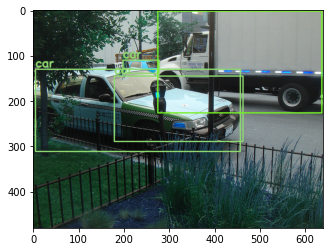

In [ ]:
from PIL import Image
import matplotlib.pyplot  as plt
retina.eval().to(device)
image = Image.open('/content/000000000001.jpg').convert('RGB')
image_array = np.array(image)
image_array = cv2.cvtColor(image_array, cv2.COLOR_RGB2BGR)
boxes, classes = predict(image, retina, device, 0.5)
result = draw_boxes(boxes, classes, image_array)

plt.imshow(result)